In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-without-drift/train_clean.csv
/kaggle/input/data-without-drift/test_clean.csv
/kaggle/input/liverpool-ion-switching/train.csv
/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv


In [2]:
# imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from keras.models import Model
import keras.layers as L
import lightgbm as lgb

Using TensorFlow backend.


# Load data
Thanks to https://www.kaggle.com/cdeotte/data-without-drift.

In [3]:
# read data
data = pd.read_csv('../input/data-without-drift/train_clean.csv')
data.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


# Feature engineering
Add to signal several other signals: gradients, rolling mean, std, low/high pass filters...

FE is the same as this notebook https://www.kaggle.com/martxelo/fe-and-simple-mlp with corrections in filters.

In [4]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [5]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [6]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [7]:
def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [8]:
def calc_ewm(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [9]:
def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)


def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

In [10]:
# apply every feature to data
df = divide_and_add_features(data['signal'])
df.head()

100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,...,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000
0,-0.184000,-0.006380,0.018133,-0.019688,0.001474,-0.184000,-0.186104,-0.184000,-0.186360,-0.184000,...,-0.184000,0.000000,-0.184000,0.000000,-0.184000,0.000000,-0.184000,0.000000,-0.184000,0.000000
1,-0.190380,0.011753,-0.001555,-0.018214,0.013497,-0.184099,-0.186085,-0.184151,-0.186375,-0.184231,...,-0.187509,0.004511,-0.187254,0.004511,-0.187222,0.004511,-0.187196,0.004511,-0.187193,0.004511
2,-0.160493,-0.009490,-0.018295,0.007305,0.018674,-0.183831,-0.186072,-0.183738,-0.186402,-0.183595,...,-0.176649,0.016610,-0.177975,0.015919,-0.178134,0.015830,-0.178260,0.015758,-0.178275,0.015749
3,-0.209360,-0.024837,0.013055,0.019133,-0.008792,-0.183865,-0.186064,-0.183795,-0.186444,-0.183691,...,-0.187426,0.022033,-0.186298,0.020534,-0.186176,0.020348,-0.186082,0.020199,-0.186070,0.020180
4,-0.210167,0.016620,0.019972,-0.010280,-0.016318,-0.184666,-0.186045,-0.185025,-0.186460,-0.185576,...,-0.193954,0.021459,-0.191461,0.020752,-0.191168,0.020639,-0.190937,0.020545,-0.190909,0.020533


Let's plot the signals to see how they look like.

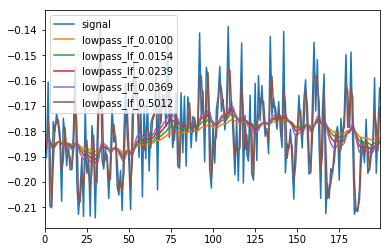

In [11]:
# The low pass lfilter captures the trend of the signal for different cutoff frequencies
df[['signal',
    'lowpass_lf_0.0100',
    'lowpass_lf_0.0154',
    'lowpass_lf_0.0239',
    'lowpass_lf_0.0369',
    'lowpass_lf_0.5012']].iloc[:200].plot()

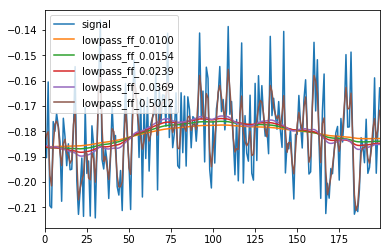

In [12]:
# The low pass filtfilt captures the trend of the signal for different cutoff frequencies
# but without delay
df[['signal',
    'lowpass_ff_0.0100',
    'lowpass_ff_0.0154',
    'lowpass_ff_0.0239',
    'lowpass_ff_0.0369',
    'lowpass_ff_0.5012']].iloc[:200].plot()

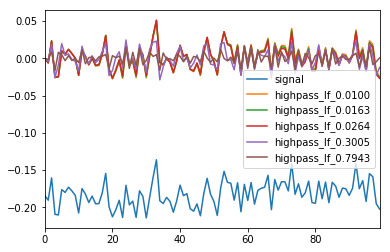

In [13]:
# The high pass lfilter captures fast variation of the signal for different cutoff frequencies
df[['signal',
    'highpass_lf_0.0100',
    'highpass_lf_0.0163',
    'highpass_lf_0.0264',
    'highpass_lf_0.3005',
    'highpass_lf_0.7943']].iloc[:100].plot()

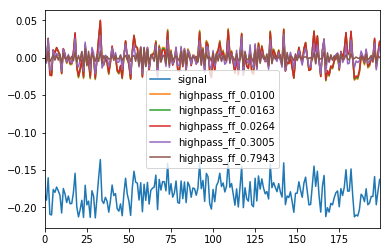

In [14]:
# The high pass lfilter captures fast variation of the signal for different cutoff frequencies
# but without delay
df[['signal',
    'highpass_ff_0.0100',
    'highpass_ff_0.0163',
    'highpass_ff_0.0264',
    'highpass_ff_0.3005',
    'highpass_ff_0.7943']].iloc[:200].plot()

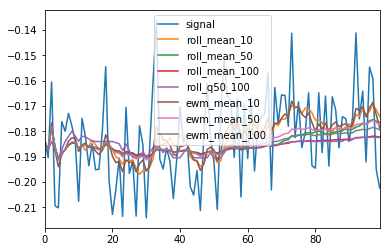

In [15]:
# rolling mean, quantiles and ewm also capture the trend
df[['signal',
    'roll_mean_10',
    'roll_mean_50',
    'roll_mean_100',
    'roll_q50_100',
    'ewm_mean_10',
    'ewm_mean_50',
    'ewm_mean_100']].iloc[:100].plot()

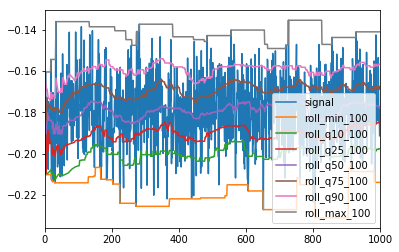

In [16]:
# quantiles, min, max
df[['signal',
    'roll_min_100',
    'roll_q10_100',
    'roll_q25_100',
    'roll_q50_100',
    'roll_q75_100',
    'roll_q90_100',
    'roll_max_100']].iloc[:1000].plot()

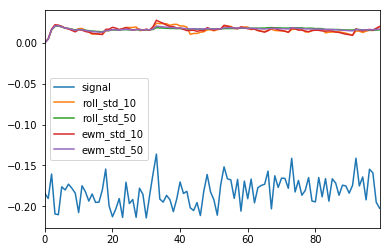

In [17]:
# rolling std, and emw std
df[['signal',
    'roll_std_10',
    'roll_std_50',
    'ewm_std_10',
    'ewm_std_50']].iloc[:100].plot()

# Divide in train and test

In [18]:
# Get train and test data
x_train, x_test, y_train, y_test = train_test_split(df.values, data['open_channels'].values, test_size=0.2)

del data, df
print('x_train.shape=', x_train.shape)
print('x_test.shape=', x_test.shape)
print('y_train.shape=', y_train.shape)
print('y_test.shape=', y_test.shape)

x_train.shape= (4000000, 105)
x_test.shape= (1000000, 105)
y_train.shape= (4000000,)
y_test.shape= (1000000,)


# Classes weights

class_weight= [  4.03034852   5.07153399   9.03154719   7.48140404  12.4045624
  18.01071638  26.54702806  18.85556168  20.36411029  36.74545505
 139.78682509]


Text(0.5, 1.0, 'class_weight')

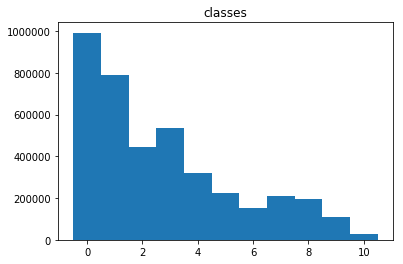

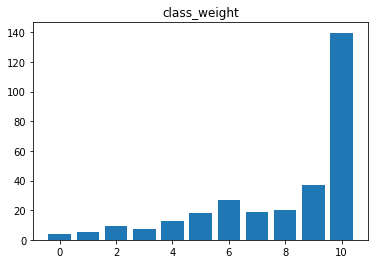

In [19]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = get_class_weight(y_train)
print('class_weight=', class_weight)
plt.figure()
plt.title('classes')
plt.hist(y_train, bins=np.arange(12)-0.5)
plt.figure()
plt.title('class_weight')
plt.bar(np.arange(11), class_weight)
plt.title('class_weight')

# Build a MLP model

In [20]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


mlp = create_mpl(x_train[0].shape)
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(mlp.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 105)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15900     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 125)               18875     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12600     
_________________________________________________________________
dense_5 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                3800

In [21]:
# fit the model
mlp.fit(x=x_train, y=y_train, epochs=30, batch_size=1024, class_weight=class_weight)

Epoch 1/30
4000000/4000000 [==============================] - 49s 12us/step - loss: 0.1223 - sparse_categorical_accuracy: 0.9551
Epoch 2/30
4000000/4000000 [==============================] - 49s 12us/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9643
Epoch 3/30
4000000/4000000 [==============================] - 48s 12us/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9650
Epoch 4/30
4000000/4000000 [==============================] - 49s 12us/step - loss: 0.0886 - sparse_categorical_accuracy: 0.9656
Epoch 5/30
4000000/4000000 [==============================] - 48s 12us/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9661
Epoch 6/30
4000000/4000000 [==============================] - 48s 12us/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9663
Epoch 7/30
4000000/4000000 [==============================] - 50s 13us/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9667
Epoch 8/30
4000000/4000000 [==============================] - 49s 12us/step - loss: 0.0855 - spar

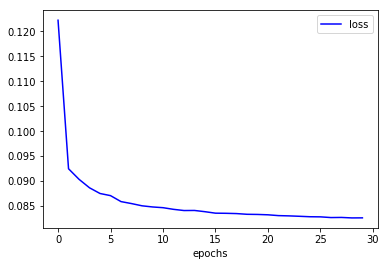

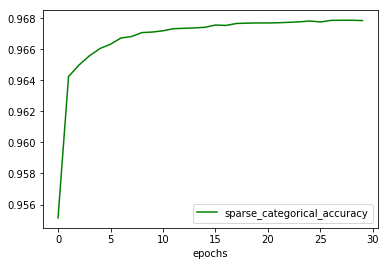

In [22]:
# plot history
plt.figure(1)
plt.plot(mlp.history.history['loss'], 'b', label='loss')
plt.xlabel('epochs')
plt.legend()
plt.figure(2)
plt.plot(mlp.history.history['sparse_categorical_accuracy'], 'g', label='sparse_categorical_accuracy')
plt.xlabel('epochs')
plt.legend()

In [23]:
# predict on test
mlp_pred = mlp.predict(x_test)
print('mlp_pred.shape=', mlp_pred.shape)

mlp_pred.shape= (1000000, 11)


# Build LGBM model
Parameters from https://www.kaggle.com/ragnar123/single-model-lgbm. Thanks!

In [24]:
# build model
dataset = lgb.Dataset(x_train, label=y_train)
params = {'boosting_type': 'gbdt',
          'metric': 'rmse',
          'objective': 'regression',
          'n_jobs': -1,
          'seed': 236,
          'num_leaves': 280,
          'learning_rate': 0.026623466966581126,
          'max_depth': 73,
          'lambda_l1': 2.959759088169741,
          'lambda_l2': 1.331172832164913,
          'bagging_fraction': 0.9655406551472153,
          'bagging_freq': 9,
          'colsample_bytree': 0.6867118652742716}

In [25]:
# fit the model
print('Training LGBM...')
gbc = lgb.train(params, dataset,
                num_boost_round=10000,
                verbose_eval=100)
print('LGBM trained!')

Training LGBM...
LGBM trained!


In [26]:
# predict on test
gbc_pred = gbc.predict(x_test)
print('gbc_pred.shape=', gbc_pred.shape)

gbc_pred.shape= (1000000,)


In [27]:
def convert_to_one_hot(pred):
    '''
    Convert the prediction into probabilities
    Example: 1.6 --> [0, 0.4, 0.6, 0, 0, ...]
    1.6 is closer to 2 than to 1
    All rows will sum 1
    '''

    # clip results lower or higher than limits
    pred = np.clip(pred, 0, 10)

    # convert to "one-hot"
    pred = 1 - np.abs(pred.reshape((-1,1)) - np.arange(11))

    # clip results lower than 0
    pred = np.clip(pred, 0, 1)
    
    return pred
    
gbc_pred = convert_to_one_hot(gbc_pred)

print('gbc_pred.shape=', gbc_pred.shape)

gbc_pred.shape= (1000000, 11)


# Ensemble
The idea is to mix both results with a parameter alpha ($0\le\alpha\le1$):

$y_{pred}=\alpha·mlp_{pred} + (1-\alpha)·gbc_{pred}$

In [28]:
# lists for keep results
f1s = []
alphas = np.linspace(0,1,101)

# loop for every alpha
for alpha in tqdm(alphas):
    y_pred = alpha*mlp_pred + (1 - alpha)*gbc_pred
    f1 = f1_score(y_test, np.argmax(y_pred, axis=-1), average='macro')
    f1s.append(f1)

# convert to numpy array
f1s = np.array(f1s)

# get best_alpha
best_alpha = alphas[np.argmax(f1s)]

print('best_f1=', f1s.max())
print('best_alpha=', best_alpha)

100%|██████████| 101/101 [01:00<00:00,  1.67it/s]

best_f1= 0.9390859404409908
best_alpha= 0.02


Text(0, 0.5, 'f1_score')

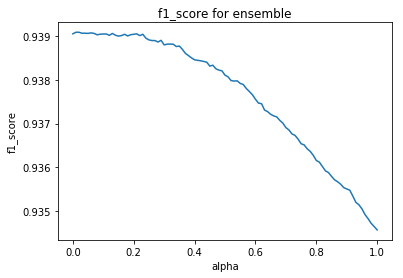

In [29]:
plt.plot(alphas, f1s)
plt.title('f1_score for ensemble')
plt.xlabel('alpha')
plt.ylabel('f1_score')

# Confusion matrix

In [30]:
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title):
    figsize=(16,16)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap='viridis', annot=annot, fmt='', ax=ax)

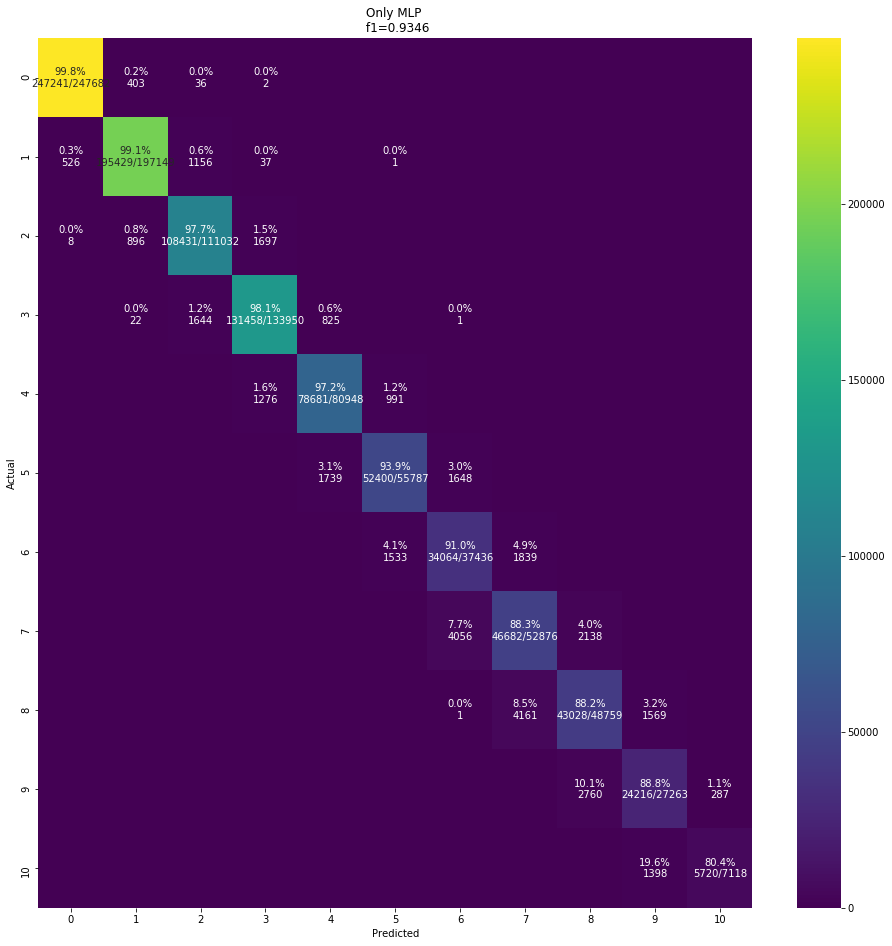

In [31]:
f1_mlp = f1_score(y_test, np.argmax(mlp_pred, axis=-1), average='macro')
plot_cm(y_test, np.argmax(mlp_pred, axis=-1), 'Only MLP \n f1=' + str('%.4f' %f1_mlp))

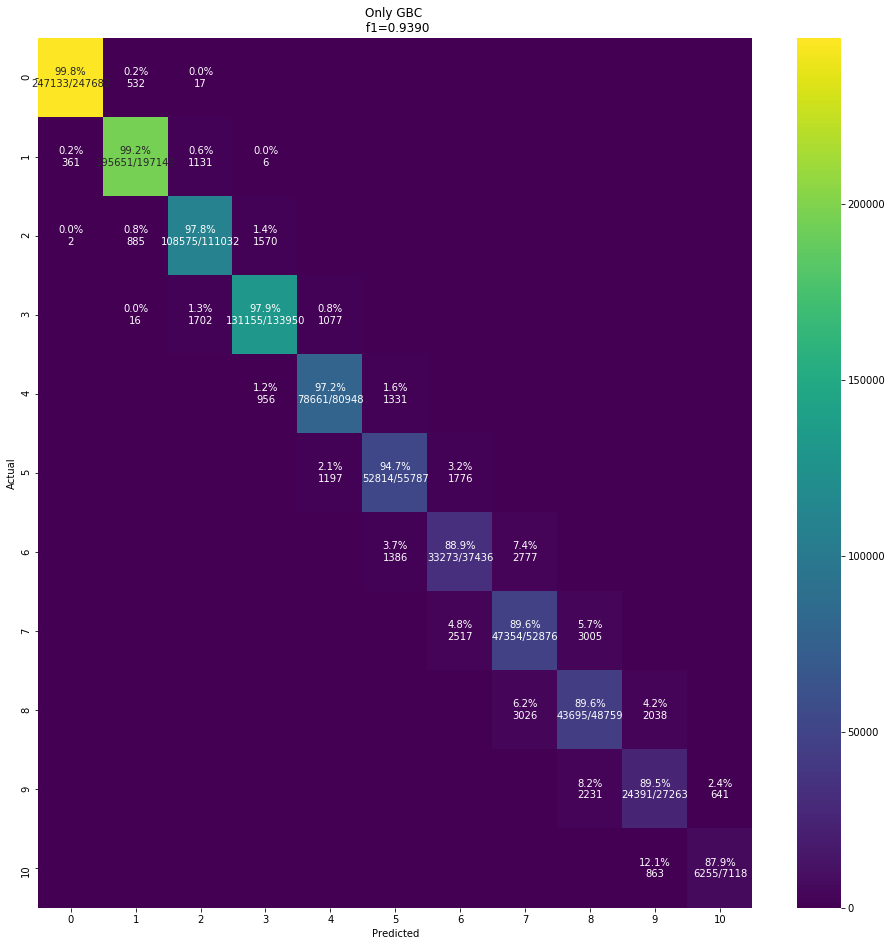

In [32]:
f1_gbc = f1_score(y_test, np.argmax(gbc_pred, axis=-1), average='macro')
plot_cm(y_test, np.argmax(gbc_pred, axis=-1), 'Only GBC \n f1=' + str('%.4f' %f1_gbc))

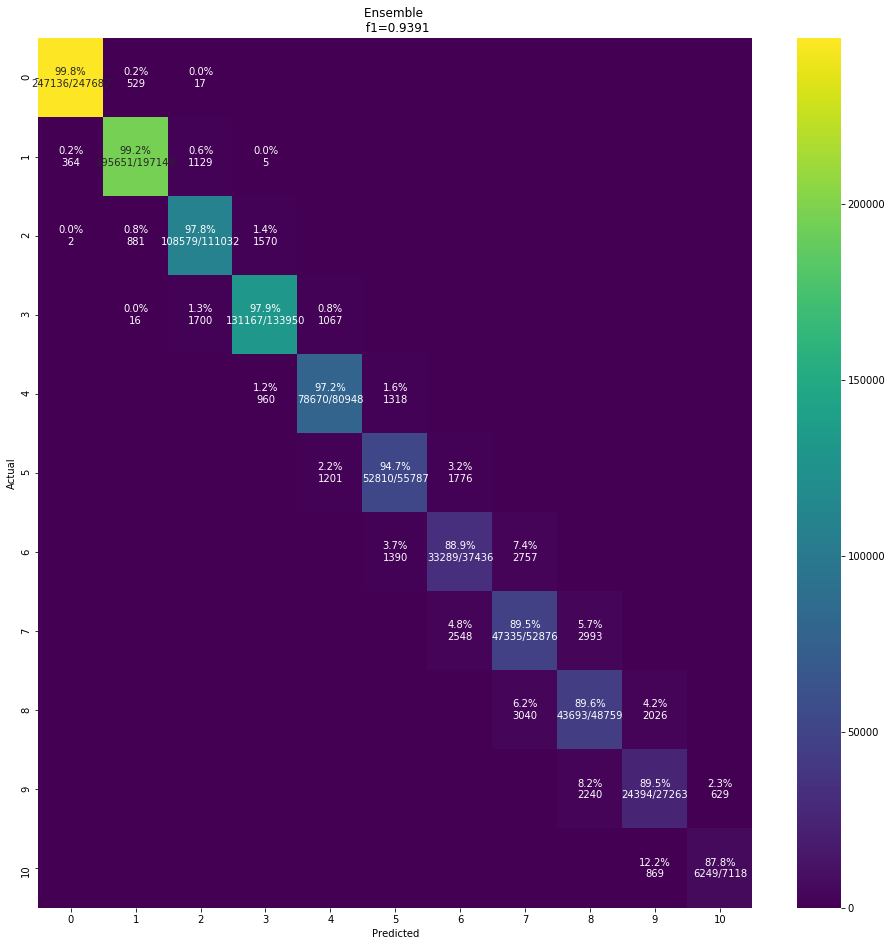

In [33]:
y_pred = best_alpha*mlp_pred + (1 - best_alpha)*gbc_pred
f1_ens = f1_score(y_test, np.argmax(y_pred, axis=-1), average='macro')
plot_cm(y_test, np.argmax(y_pred, axis=-1), 'Ensemble \n f1=' + str('%.4f' %f1_ens))

# Submit result

In [34]:
def submit_result(mlp, gbc, alpha):
    
    print('Reading data...')
    data = pd.read_csv('../input/data-without-drift/test_clean.csv')
    
    print('Feature engineering...')
    df = divide_and_add_features(data['signal'])
    
    print('Predicting MLP...')
    mlp_pred = mlp.predict(df.values)
    
    print('Predicting GBC...')
    gbc_pred = gbc.predict(df.values)
    gbc_pred = convert_to_one_hot(gbc_pred)
    
    print('Ensembling...')
    y_pred = alpha*mlp_pred + (1 - alpha)*gbc_pred
    y_pred = np.argmax(y_pred, axis=-1)
    
    print('Writing submission...')
    submission = pd.DataFrame()
    submission['time'] = data['time']
    submission['open_channels'] = y_pred
    submission.to_csv('submission.csv', index=False, float_format='%.4f')
    
    print('Submission finished!')

In [35]:
submit_result(mlp, gbc, best_alpha)

Reading data...


  0%|          | 0/4 [00:00<?, ?it/s]

Feature engineering...


100%|██████████| 4/4 [00:49<00:00, 12.49s/it]


Predicting MLP...
Predicting GBC...
Ensembling...
Writing submission...
Submission finished!
